### Cell 1 — Setup & chargement du réseau Bari
Objectif : charger le réseau SUMO (`bari.net.xml`), vérifier les chemins, et extraire la liste des arêtes conduisibles (`passenger`).
Sorties attendues : nombre d’arêtes `passenger` et confirmation que les fichiers existent.


In [9]:
# CELL 1 — Imports + paths + SUMO tools + load Bari net

import os, sys, random, time
import numpy as np
import matplotlib.pyplot as plt

# ---- PATHS  ----
SUMO_HOME = r"C:\Program Files (x86)\Eclipse\Sumo"
PROJECT   = r"C:\Users\HIRECHE Zoulikha\Downloads\CODEPOC"

NET_PATH  = os.path.join(PROJECT, "data", "bari.net.xml")
CFG_PATH  = os.path.join(PROJECT, "data", "bari.sumocfg")
OUT_DIR   = os.path.join(PROJECT, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# SUMO tools
os.environ["SUMO_HOME"] = SUMO_HOME
sys.path.append(os.path.join(SUMO_HOME, "tools"))
import traci
import sumolib

# RL tools
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

print("NET exists:", os.path.exists(NET_PATH))
print("CFG exists:", os.path.exists(CFG_PATH))
print("OUT_DIR:", OUT_DIR)

net = sumolib.net.readNet(NET_PATH)
drivable_edges = [
    e.getID() for e in net.getEdges()
    if (not e.getID().startswith(":")) and e.allows("passenger")
]
print("✅ Drivable passenger edges:", len(drivable_edges))

NET exists: True
CFG exists: True
OUT_DIR: C:\Users\HIRECHE Zoulikha\Downloads\CODEPOC\outputs
✅ Drivable passenger edges: 1240


### Cell 2 — Partition du réseau en 4 zones + "priority edges"
Objectif :
- découper le réseau en 4 zones (quadrants) via les médianes des coordonnées (heuristique simple et reproductible),
- approximer les "priority edges" (voies AV non disponibles dans OSM) par les 10% d’arêtes les plus rapides.

Hypothèse PoC : "priority edges" = top 10% en vitesse.


In [10]:
# CELL 2 — Zones (4) + priority_edges (top 10% fastest)

def build_zones(net, edge_ids):
    mids = {}
    xs, ys = [], []
    for eid in edge_ids:
        e = net.getEdge(eid)
        shp = e.getShape()
        mx = sum(p[0] for p in shp) / len(shp)
        my = sum(p[1] for p in shp) / len(shp)
        mids[eid] = (mx, my)
        xs.append(mx); ys.append(my)

    x_med = float(np.median(xs))
    y_med = float(np.median(ys))

    # 0: SW, 1: SE, 2: NW, 3: NE
    zones = {0: [], 1: [], 2: [], 3: []}
    for eid, (mx, my) in mids.items():
        if mx <= x_med and my <= y_med:
            zones[0].append(eid)
        elif mx > x_med and my <= y_med:
            zones[1].append(eid)
        elif mx <= x_med and my > y_med:
            zones[2].append(eid)
        else:
            zones[3].append(eid)
    return zones

zones = build_zones(net, drivable_edges)
for k in range(4):
    print(f"✅ Zone {k+1} edges:", len(zones[k]))

# priority edges = top 10% highest speed
speeds = [(eid, net.getEdge(eid).getSpeed()) for eid in drivable_edges]
speeds.sort(key=lambda x: x[1], reverse=True)
k = int(0.10 * len(speeds))
priority_edges = set([eid for eid, sp in speeds[:k]])
print("✅ Priority edges (top 10% speed):", len(priority_edges))

✅ Zone 1 edges: 236
✅ Zone 2 edges: 384
✅ Zone 3 edges: 384
✅ Zone 4 edges: 236
✅ Priority edges (top 10% speed): 124


### Cell 3 — Logger d’épisodes + smoothing
Objectif : logger automatiquement les retours d’épisodes et le taux de succès via `info["episode"]` et `info["is_success"]`.
La fonction `moving_avg` sert à lisser les courbes pour la visualisation.


In [11]:
# CELL 3 — Logger + moving average

class EpisodeRewardLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.ts, self.rews, self.lens, self.succ = [], [], [], []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if isinstance(info, dict) and "episode" in info:
                self.ts.append(self.num_timesteps)
                self.rews.append(info["episode"]["r"])
                self.lens.append(info["episode"].get("l", 0))
                self.succ.append(int(info.get("is_success", 0)))
        return True

def moving_avg(x, w=15):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

### Cell 4 — Environnement Gym (SUMO/TraCI)
Objectif : définir l’environnement RL (MDP) :
- état : [x, y, angle, edge_index]
- actions : {0: keep route, 1: rerouteTraveltime}
- reward : progrès + pénalité de virage + bonus "priority" - pénalité de step + bonus terminal


In [12]:
# CELL 4 — POC Env (SUMO) with robust episode logging inside env

class PaperLikeRouteEnv(gym.Env):
    """
    POC:
    - action 0: keep route
    - action 1: rerouteTraveltime (SUMO internal reroute)
    - every decision_interval seconds, agent acts once
    - reward: (progress + turn_penalty + priority_bonus) - step_penalty, terminal bonus
    - logs "episode" in info so curves are never empty
    """

    metadata = {"render_modes": []}

    def __init__(
        self,
        cfg_path,
        net_path,
        allowed_edges,
        priority_edges,
        use_gui=False,
        seed=0,
        max_decisions=120,
        decision_interval=5,
        phi_deg=45.0,
        step_penalty=0.28,
        terminal_bonus=6.0,
    ):
        super().__init__()
        self.rng = random.Random(seed)

        self.cfg_path = cfg_path
        self.net = sumolib.net.readNet(net_path)
        self.allowed_edges = list(allowed_edges)
        self.priority_edges = set(priority_edges)

        self.max_decisions = int(max_decisions)
        self.decision_interval = int(decision_interval)
        self.phi_deg = float(phi_deg)
        self.step_penalty = float(step_penalty)
        self.terminal_bonus = float(terminal_bonus)

        self.edges = [e.getID() for e in self.net.getEdges() if not e.getID().startswith(":")]
        self.edge_to_idx = {eid: i for i, eid in enumerate(self.edges)}

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=np.array([-1e9, -1e9,   0.0, 0.0], dtype=np.float32),
            high=np.array([ 1e9,  1e9, 360.0, float(len(self.edges) - 1)], dtype=np.float32),
            dtype=np.float32,
        )

        exe = "sumo-gui.exe" if use_gui else "sumo.exe"
        self.sumo_bin = os.path.join(SUMO_HOME, "bin", exe)

        self.veh_id = "ego"
        self.goal_edge = None
        self.prev_tt = None
        self.prev_angle = 0.0
        self.last_real_edge = None
        self.decisions = 0

        self.ep_return = 0.0
        self.ep_len = 0
        self.ep_success = 0

    def _close(self):
        try:
            traci.close()
        except:
            pass

    def close(self):
        self._close()

    def _start(self):
        traci.start([
            self.sumo_bin,
            "-c", self.cfg_path,
            "--no-step-log", "true",
            "--time-to-teleport", "-1",
            "--ignore-route-errors", "true",
            "--quit-on-end", "false",
            "--start",
        ])

    def _ego_exists(self):
        try:
            return self.veh_id in traci.vehicle.getIDList()
        except:
            return False

    def _remove_ego_if_exists(self):
        try:
            if self.veh_id in traci.vehicle.getIDList():
                traci.vehicle.remove(self.veh_id)
        except:
            pass

    def _safe_edge(self):
        if not self._ego_exists():
            return self.last_real_edge if self.last_real_edge else self.allowed_edges[0]
        rid = traci.vehicle.getRoadID(self.veh_id)
        if rid and not rid.startswith(":"):
            self.last_real_edge = rid
        return self.last_real_edge if self.last_real_edge else self.allowed_edges[0]

    def _tt_to_goal(self, from_edge):
        try:
            rr = traci.simulation.findRoute(from_edge, self.goal_edge)
            if rr is None or rr.edges is None or len(rr.edges) == 0:
                return float("inf")
            if not np.isfinite(rr.travelTime):
                return float("inf")
            return float(rr.travelTime)
        except:
            return float("inf")

    def _obs(self):
        if not self._ego_exists():
            return np.zeros(4, dtype=np.float32)
        x, y = traci.vehicle.getPosition(self.veh_id)
        ang = float(traci.vehicle.getAngle(self.veh_id))
        eid = self._safe_edge()
        return np.array([x, y, ang, float(self.edge_to_idx.get(eid, 0))], dtype=np.float32)

    def _angle_diff(self, a, b):
        d = (a - b + 180.0) % 360.0 - 180.0
        return abs(d)

    def _sample_connected_pair(self, tries=300):
        for _ in range(tries):
            s = self.rng.choice(self.allowed_edges)
            g = self.rng.choice(self.allowed_edges)
            if s == g:
                continue
            try:
                rr = traci.simulation.findRoute(s, g)
                if rr is not None and rr.edges and np.isfinite(rr.travelTime):
                    return s, g, rr
            except:
                pass
        raise RuntimeError("No connected start/goal pair found")

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._close()
        self._start()

        self.decisions = 0
        self.last_real_edge = None

        self.ep_return = 0.0
        self.ep_len = 0
        self.ep_success = 0

        self._remove_ego_if_exists()

        s, g, rr = self._sample_connected_pair()
        self.goal_edge = g

        traci.route.add("r0", rr.edges)
        traci.vehicle.add(self.veh_id, "r0")
        traci.simulationStep()

        self.last_real_edge = s
        curr_edge = self._safe_edge()
        self.prev_tt = self._tt_to_goal(curr_edge)
        self.prev_angle = float(traci.vehicle.getAngle(self.veh_id)) if self._ego_exists() else 0.0

        return self._obs(), {"start_edge": s, "goal_edge": g}

    def step(self, action):
        action = int(action)
        self.decisions += 1

        info = {}

        if not self._ego_exists():
            reward = -5.0
            terminated = True
            truncated = False
            info["missing_vehicle"] = True
            return self._finish_step(reward, terminated, truncated, info)

        if action == 1:
            rid = traci.vehicle.getRoadID(self.veh_id)
            if rid and not rid.startswith(":"):
                try:
                    traci.vehicle.rerouteTraveltime(self.veh_id)
                except:
                    pass

        for _ in range(self.decision_interval):
            traci.simulationStep()
            if not self._ego_exists():
                break

        if not self._ego_exists():
            reward = -5.0
            terminated = True
            truncated = False
            info["missing_vehicle"] = True
            return self._finish_step(reward, terminated, truncated, info)

        curr_edge = self._safe_edge()
        curr_tt = self._tt_to_goal(curr_edge)
        curr_angle = float(traci.vehicle.getAngle(self.veh_id))

        # paper-like components (bounded)
        r_short = 1.0 if (np.isfinite(curr_tt) and np.isfinite(self.prev_tt) and curr_tt < self.prev_tt) else -0.5
        r_turn  = -1.0 if self._angle_diff(curr_angle, self.prev_angle) >= self.phi_deg else 0.0
        r_prio  = 1.0 if curr_edge in self.priority_edges else 0.0

        reward = (r_short + r_turn + r_prio) - self.step_penalty

        terminated = (curr_edge == self.goal_edge)
        truncated  = (self.decisions >= self.max_decisions)

        if terminated:
            reward += self.terminal_bonus
            self.ep_success = 1

        self.prev_tt = curr_tt
        self.prev_angle = curr_angle

        info.update({"edge": curr_edge, "tt_to_goal": curr_tt, "goal_edge": self.goal_edge})
        return self._finish_step(reward, terminated, truncated, info)

    def _finish_step(self, reward, terminated, truncated, info):
        self.ep_return += float(reward)
        self.ep_len += 1

        done = bool(terminated or truncated)
        info["is_success"] = int(self.ep_success if done else 0)

        if done:
            info["episode"] = {"r": float(self.ep_return), "l": int(self.ep_len)}

        return self._obs(), float(reward), bool(terminated), bool(truncated), info

### Cell 5 — Entraînement agent global (PPO)
Objectif : entraîner un agent PPO sur tout le réseau (1240 arêtes passenger) et enregistrer une courbe d’apprentissage + modèle.


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -10.4    |
|    success_rate    | 0.357    |
| time/              |          |
|    fps             | 30       |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 512      |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 36.5       |
|    ep_rew_mean          | -6.79      |
|    success_rate         | 0.407      |
| time/                   |            |
|    fps                  | 32         |
|    iterations           | 2          |
|    time_elapsed         | 31         |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.01581413 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |


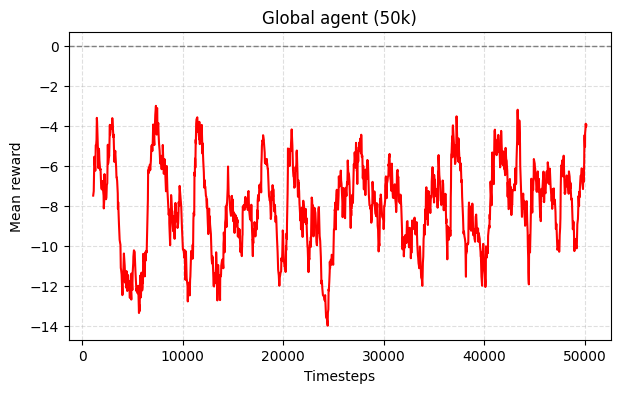

✅ Figure saved: C:\Users\HIRECHE Zoulikha\Downloads\CODEPOC\outputs\global_50k.png
Global last-50 mean reward: -6.563599999999999
Global last-50 success rate: 0.48


In [13]:
# CELL 5 — Train 1 Global agent (50k) + plot

TIMESTEPS_GLOBAL = 50_000

global_env = Monitor(PaperLikeRouteEnv(
    cfg_path=CFG_PATH,
    net_path=NET_PATH,
    allowed_edges=drivable_edges,
    priority_edges=priority_edges,
    use_gui=False,
    seed=0,
    max_decisions=120,
    decision_interval=5,
    phi_deg=45.0,
    step_penalty=0.28,
    terminal_bonus=6.0
))

global_logger = EpisodeRewardLogger()

global_model = PPO(
    "MlpPolicy",
    global_env,
    verbose=1,
    learning_rate=2.5e-4,
    n_steps=512,
    batch_size=64,
    device="cpu",
)

global_model.learn(total_timesteps=TIMESTEPS_GLOBAL, callback=global_logger)
global_env.close()

global_model_path = os.path.join(OUT_DIR, "ppo_global_50k")
global_model.save(global_model_path)
print("✅ Saved:", global_model_path)

xs = np.array(global_logger.ts)
ys = np.array(global_logger.rews)
ys_s = moving_avg(ys, w=30)            # smoothing a bit stronger for 50k
xs_s = xs[-len(ys_s):]

plt.figure(figsize=(7,4))
plt.plot(xs_s, ys_s, color="red", linewidth=1.5)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel("Timesteps")
plt.ylabel("Mean reward")
plt.title("Global agent (50k)")

global_fig = os.path.join(OUT_DIR, "global_50k.png")
plt.savefig(global_fig, dpi=200)
plt.show()
print("✅ Figure saved:", global_fig)

print("Global last-50 mean reward:", float(np.mean(ys[-50:])) if len(ys) >= 50 else float(np.mean(ys)))
print("Global last-50 success rate:", float(np.mean(global_logger.succ[-50:])) if len(global_logger.succ) >= 50 else float(np.mean(global_logger.succ)))


### Cell 6 — Entraînement modulaire : 4 agents (1 par zone)
Objectif : entraîner un agent PPO par zone et tracer 4 courbes.



🚀 Training Agent 1 (Zone 1) ...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | -6.87    |
|    success_rate    | 0.562    |
| time/              |          |
|    fps             | 23       |
|    iterations      | 1        |
|    time_elapsed    | 22       |
|    total_timesteps | 512      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 35.9          |
|    ep_rew_mean          | -11.6         |
|    success_rate         | 0.407         |
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 2             |
|    time_elapsed         | 38            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00044978864 |
|    clip_fra

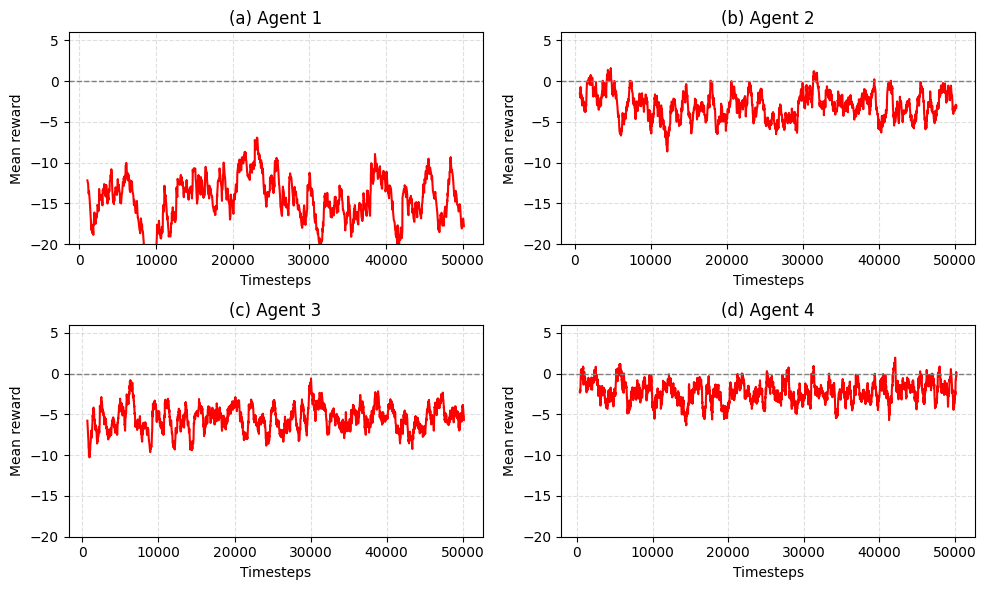

✅ Figure saved: C:\Users\HIRECHE Zoulikha\Downloads\CODEPOC\outputs\fig5_like_modular_50k.png


In [14]:
# CELL 6 — Train 4 Modular agents (Zone 1..4) (50k each) + Fig.5-like plot

TIMESTEPS_PER_AGENT = 50_000
SEEDS = [1, 2, 3, 4]

logs = []
models = []

for i, sd in enumerate(SEEDS):
    print(f"\n🚀 Training Agent {i+1} (Zone {i+1}) ...")

    env = Monitor(PaperLikeRouteEnv(
        cfg_path=CFG_PATH,
        net_path=NET_PATH,
        allowed_edges=zones[i],
        priority_edges=priority_edges,
        use_gui=False,
        seed=sd,
        max_decisions=120,
        decision_interval=5,
        phi_deg=45.0,
        step_penalty=0.28,
        terminal_bonus=6.0
    ))

    logger = EpisodeRewardLogger()

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=2.5e-4,
        n_steps=512,
        batch_size=64,
        device="cpu",
    )

    model.learn(total_timesteps=TIMESTEPS_PER_AGENT, callback=logger)

    model_path = os.path.join(OUT_DIR, f"ppo_zone{i+1}_50k")
    model.save(model_path)

    env.close()
    logs.append(logger)
    models.append(model)

    print(f"✅ Saved: {model_path}")
    print("  last-50 mean reward:", float(np.mean(logger.rews[-50:])) if len(logger.rews) >= 50 else float(np.mean(logger.rews)))
    print("  last-50 success rate:", float(np.mean(logger.succ[-50:])) if len(logger.succ) >= 50 else float(np.mean(logger.succ)))

# Plot 2x2 like paper
plt.figure(figsize=(10, 6))

for i in range(4):
    plt.subplot(2, 2, i+1)
    xs = np.array(logs[i].ts)
    ys = np.array(logs[i].rews)

    ys_s = moving_avg(ys, w=30)       # smoother for 50k
    xs_s = xs[-len(ys_s):]

    plt.plot(xs_s, ys_s, color="red", linewidth=1.5)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"({chr(97+i)}) Agent {i+1}")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean reward")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.ylim(-20, 6)

plt.tight_layout()
fig5_path = os.path.join(OUT_DIR, "fig5_like_modular_50k.png")
plt.savefig(fig5_path, dpi=200)
plt.show()
print("✅ Figure saved:", fig5_path)


### Cell 7 — Évaluation (Global + Zonal)
Objectif : évaluer chaque politique sur des épisodes nouveaux (sans apprentissage) et calculer :
mean_reward, std_reward, mean_len, success_rate.


In [17]:
# CELL 7 — Evaluation utilities (stable) + evaluate Global & Zone models

import numpy as np

def evaluate_model(model, allowed_edges, n_episodes=30, seed=123, deterministic=True):
    """
    Evaluate a trained model on fresh episodes (fixed policy, no learning).
    Returns mean_reward, std_reward, mean_len, success_rate.
    """
    rewards = []
    lengths = []
    successes = []

    # new env instance (important: evaluation should not reuse training env)
    env = PaperLikeRouteEnv(
        cfg_path=CFG_PATH,
        net_path=NET_PATH,
        allowed_edges=allowed_edges,
        priority_edges=priority_edges,
        use_gui=False,
        seed=seed,
        max_decisions=120,
        decision_interval=5,
        phi_deg=45.0,
        step_penalty=0.28,
        terminal_bonus=6.0
    )

    for ep in range(n_episodes):
        obs, info = env.reset(seed=seed + ep)
        done = False
        ep_ret = 0.0
        ep_len = 0
        last_info = {}

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, step_info = env.step(action)
            ep_ret += float(r)
            ep_len += 1
            last_info = step_info
            done = terminated or truncated

        rewards.append(ep_ret)
        lengths.append(ep_len)
        successes.append(int(last_info.get("is_success", 0)))

    env.close()

    return {
        "episodes": n_episodes,
        "mean_reward": float(np.mean(rewards)),
        "std_reward": float(np.std(rewards)),
        "mean_len": float(np.mean(lengths)),
        "success_rate": float(np.mean(successes)),
    }


# ---- Evaluate global model ----
global_eval = evaluate_model(global_model, drivable_edges, n_episodes=30, seed=555)
print("GLOBAL EVAL:", global_eval)

# ---- Evaluate modular (zone) models ----
zone_evals = []
for i in range(4):
    ev = evaluate_model(models[i], zones[i], n_episodes=30, seed=600+i)
    zone_evals.append(ev)
    print(f"ZONE {i+1} EVAL:", ev)


GLOBAL EVAL: {'episodes': 30, 'mean_reward': -3.3806666666666705, 'std_reward': 11.7668942187629, 'mean_len': 28.533333333333335, 'success_rate': 0.43333333333333335}
ZONE 1 EVAL: {'episodes': 30, 'mean_reward': -13.256000000000013, 'std_reward': 15.962121329363896, 'mean_len': 41.56666666666667, 'success_rate': 0.4666666666666667}
ZONE 2 EVAL: {'episodes': 30, 'mean_reward': -4.816666666666671, 'std_reward': 7.297119218492246, 'mean_len': 22.266666666666666, 'success_rate': 0.4}
ZONE 3 EVAL: {'episodes': 30, 'mean_reward': -7.131333333333333, 'std_reward': 7.918792304105185, 'mean_len': 23.9, 'success_rate': 0.36666666666666664}
ZONE 4 EVAL: {'episodes': 30, 'mean_reward': -1.0120000000000007, 'std_reward': 8.643754739695012, 'mean_len': 15.966666666666667, 'success_rate': 0.43333333333333335}


### Cell 8 — Manager (sélection du meilleur agent par épisode)
Objectif : approximer l’idée de "manager" : pour chaque épisode, exécuter les 4 agents zonés et retenir celui qui maximise le retour.
Limite PoC : chaque agent est évalué sur son sous-réseau (comparaison potentiellement optimiste).


In [18]:
# CELL 8 — Modular manager: pick best zone model per episode + compare to global

def evaluate_manager(models, zones, n_episodes=30, seed=900, deterministic=True):
    """
    Manager evaluation:
    For each episode, run ALL zone models on the SAME (seeded) episode setting,
    and keep the best return among them (best agent wins).
    This approximates the paper's manager selection idea.
    """
    best_rewards = []
    best_success = []
    chosen_zone = []

    for ep in range(n_episodes):
        ep_seed = seed + ep

        # run each zone model on its own allowed_edges but same seed for reproducibility
        zone_results = []
        for zi in range(4):
            res = evaluate_model(models[zi], zones[zi], n_episodes=1, seed=ep_seed, deterministic=deterministic)
            zone_results.append(res)

        # choose zone with maximum mean_reward (since n_episodes=1, it's the episode return)
        best_idx = int(np.argmax([z["mean_reward"] for z in zone_results]))
        best_rewards.append(zone_results[best_idx]["mean_reward"])
        best_success.append(zone_results[best_idx]["success_rate"])
        chosen_zone.append(best_idx + 1)

    return {
        "episodes": n_episodes,
        "mean_reward": float(np.mean(best_rewards)),
        "std_reward": float(np.std(best_rewards)),
        "success_rate": float(np.mean(best_success)),
        "chosen_zone_counts": {z: chosen_zone.count(z) for z in [1,2,3,4]},
    }


# ---- Evaluate manager vs global ----
manager_eval = evaluate_manager(models, zones, n_episodes=30, seed=999)
print("MANAGER EVAL:", manager_eval)

print("\n=== SUMMARY ===")
print(f"GLOBAL   mean return: {global_eval['mean_reward']:.3f}  success: {global_eval['success_rate']:.3f}")
print(f"MANAGER  mean return: {manager_eval['mean_reward']:.3f}  success: {manager_eval['success_rate']:.3f}")
print("Manager chosen zone counts:", manager_eval["chosen_zone_counts"])


MANAGER EVAL: {'episodes': 30, 'mean_reward': 6.035999999999998, 'std_reward': 4.407491803735997, 'success_rate': 0.8666666666666667, 'chosen_zone_counts': {1: 5, 2: 7, 3: 10, 4: 8}}

=== SUMMARY ===
GLOBAL   mean return: -3.381  success: 0.433
MANAGER  mean return: 6.036  success: 0.867
Manager chosen zone counts: {1: 5, 2: 7, 3: 10, 4: 8}


### Cell 9 — Tableau type Fig.7-like
Objectif : produire un tableau d’exemples par épisode (returns par zone + choix manager) et exporter en CSV.


In [21]:
# CELL 9 — Fig.7-like (table): per-episode zone returns + manager choice (no map)

import pandas as pd
import numpy as np

def eval_one_episode_return(model, allowed_edges, seed=1234, deterministic=True):
    """Run exactly 1 episode and return (episode_return, success, ep_len)."""
    env = PaperLikeRouteEnv(
        cfg_path=CFG_PATH,
        net_path=NET_PATH,
        allowed_edges=allowed_edges,
        priority_edges=priority_edges,
        use_gui=False,
        seed=seed,
        max_decisions=120,
        decision_interval=5,
        phi_deg=45.0,
        step_penalty=0.28,
        terminal_bonus=6.0
    )

    obs, _ = env.reset(seed=seed)
    done = False
    total = 0.0
    ep_len = 0
    last_info = {}

    while not done:
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, r, terminated, truncated, info = env.step(action)
        total += float(r)
        ep_len += 1
        last_info = info
        done = terminated or truncated

    env.close()
    return float(total), int(last_info.get("is_success", 0)), int(ep_len)


N_EXAMPLES = 5
rows = []

for k in range(N_EXAMPLES):
    ep_seed = 2025 + k
    zone_returns = []
    zone_succ = []
    zone_len = []

    for zi in range(4):
        ret, suc, ln = eval_one_episode_return(models[zi], zones[zi], seed=ep_seed, deterministic=True)
        zone_returns.append(ret)
        zone_succ.append(suc)
        zone_len.append(ln)

    best_idx = int(np.argmax(zone_returns))  # manager picks best return
    rows.append({
        "episode_seed": ep_seed,
        "z1_return": zone_returns[0], "z1_succ": zone_succ[0], "z1_len": zone_len[0],
        "z2_return": zone_returns[1], "z2_succ": zone_succ[1], "z2_len": zone_len[1],
        "z3_return": zone_returns[2], "z3_succ": zone_succ[2], "z3_len": zone_len[2],
        "z4_return": zone_returns[3], "z4_succ": zone_succ[3], "z4_len": zone_len[3],
        "manager_choice_zone": best_idx + 1,
        "manager_best_return": zone_returns[best_idx],
        "manager_best_success": zone_succ[best_idx],
        "manager_best_len": zone_len[best_idx],
    })

df = pd.DataFrame(rows)
display(df)

csv_path = os.path.join(OUT_DIR, "fig7_like_table_examples.csv")
df.to_csv(csv_path, index=False)
print("✅ Saved table to:", csv_path)


,episode_seed,z1_return,z1_succ,z1_len,z2_return,z2_succ,z2_len,z3_return,z3_succ,z3_len,z4_return,z4_succ,z4_len,manager_choice_zone,manager_best_return,manager_best_success,manager_best_len
0,2025,-42.38,0,97,4.40,1,20,6.14,1,12,-2.46,1,32,3,6.14,1,12
1,2026,-14.46,0,58,-2.28,1,26,-5.40,0,6,-7.38,0,22,2,-2.28,1,26
2,2027,16.00,1,25,-3.06,0,28,6.74,1,17,-7.64,0,14,1,16.00,1,25
3,2028,-11.22,0,50,1.14,0,38,-30.54,0,44,-1.82,1,19,2,1.14,0,38
4,2029,-5.68,0,7,2.52,0,42,1.20,1,10,-11.14,0,14,2,2.52,0,42


✅ Saved table to: C:\Users\HIRECHE Zoulikha\Downloads\CODEPOC\outputs\fig7_like_table_examples.csv
